# Experiment 4: Sequential GCN with Low-Activity Filtering
# UPDATE - DO NOT USE EXP4, UNFAIR COMPARISON
This notebook implements a modified sequential training approach for the Elliptic Bitcoin dataset.

## Motivation
Previous experiments showed high volatility in model performance across timesteps. Analysis revealed that many timesteps have very few illicit transactions (e.g., < 5), making evaluation unreliable and training unstable.

## Approach
1.  **Filtering**: We filter out any timestep with **fewer than 25 illicit transactions**.
2.  **Sequential Learning**: We train a single GCN model sequentially on valid timesteps.
    *   **Init**: Train from scratch on the first valid timestep.
    *   **Loop**: For each subsequent valid timestep:
        *   **Test**: Evaluate the current model on the new timestep (Generalization).
        *   **Train**: Fine-tune the model on the new timestep (Adaptation).
3.  **Gap Handling**: Dropped timesteps are simply skipped. Since the graph snapshots are disconnected, this does not affect graph integrity.

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time
import matplotlib.pyplot as plt

# Load Data
print("Loading data...")
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns (0=txId, 1=time_step)
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]

Loading data...


In [24]:
# Data Preprocessing
print("Preprocessing data...")

# 1. Map classes: 'unknown'=0, '1'=1 (illicit), '2'=2 (licit)
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})

# 2. Merge class labels into features
df = features_df.merge(classes_df, on='txId', how='left')

# 3. Create node ID mapping
node_ids = df['txId'].values
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# 4. Prepare Edge Index
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# 5. Prepare Features and Labels tensors
x = torch.tensor(df.iloc[:, 2:-1].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.long)
time_steps = torch.tensor(df['time_step'].values, dtype=torch.long)

print(f"Nodes: {x.shape[0]}, Edges: {edge_index.shape[1]}, Features: {x.shape[1]}")

Preprocessing data...
Nodes: 203769, Edges: 234355, Features: 165


In [25]:
# Experiment 4: Filtering Logic
ILLICIT_THRESHOLD = 25

# Calculate illicit count per timestep
valid_timesteps = []
dropped_timesteps = []

print(f"Analyzing timesteps (Threshold >= {ILLICIT_THRESHOLD} illicit txs)...")
for t in range(1, 50):
    # Count illicit (class 1) in this timestep
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    if n_illicit >= ILLICIT_THRESHOLD:
        valid_timesteps.append(t)
    else:
        dropped_timesteps.append((t, n_illicit))

print(f"\nDropped {len(dropped_timesteps)} timesteps:")
for t, count in dropped_timesteps:
    print(f"  T{t}: {count} illicit txs")

print(f"\nValid Timesteps ({len(valid_timesteps)}): {valid_timesteps}")

Analyzing timesteps (Threshold >= 25 illicit txs)...

Dropped 14 timesteps:
  T1: 17 illicit txs
  T2: 18 illicit txs
  T3: 11 illicit txs
  T5: 8 illicit txs
  T6: 5 illicit txs
  T10: 18 illicit txs
  T12: 16 illicit txs
  T27: 24 illicit txs
  T33: 23 illicit txs
  T43: 24 illicit txs
  T44: 24 illicit txs
  T45: 5 illicit txs
  T46: 2 illicit txs
  T47: 22 illicit txs

Valid Timesteps (35): [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49]


In [26]:
# GCN Model Definition
class GCNFraudDetector(torch.nn.Module):
    def __init__(self, in_features, hidden=64, out_classes=3, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(in_features, hidden)
        self.gcn2 = GCNConv(hidden, hidden // 2)
        self.fc = torch.nn.Linear(hidden // 2, out_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [27]:
# Helper Functions
def compute_class_weights(labels, device):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    # Handle edge case if a class is missing (though filtering should prevent this for illicit)
    if n_illicit == 0: weight_illicit = 1.0
    else: weight_illicit = total / (2.0 * n_illicit)
        
    if n_licit == 0: weight_licit = 1.0
    else: weight_licit = total / (2.0 * n_licit)
        
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

@torch.no_grad()
def evaluate(model, x, edge_index, mask, y):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    # Metrics on masked nodes
    y_true = y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    y_probs = probs[mask][:, 1].cpu().numpy() # Prob of illicit
    
    # Binary conversion (1=illicit, 0=licit/unknown)
    # Note: We only evaluate on labeled nodes (1 or 2), so 2 becomes 0 in binary
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    return {
        'accuracy': accuracy_score(y_true_bin, y_pred_bin),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'auc_roc': roc_auc_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.5
    }

In [28]:
# Sequential Training Loop
model = GCNFraudDetector(in_features=x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Move data to device
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)
time_steps = time_steps.to(device)

results = []
NUM_EPOCHS = 50

print("Starting Sequential Training...")
print(f"{'Timestep':<10} {'Stage':<10} {'F1':<10} {'Recall':<10} {'Illicit Count'}")
print("-" * 60)

for i, t in enumerate(valid_timesteps):
    # 1. Create mask for current timestep (Labeled nodes only)
    current_mask = ((time_steps == t) & (y > 0))
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    # 2. TEST Phase (Evaluate BEFORE training on this timestep)
    # Skip for the very first valid timestep (nothing to test against yet)
    if i > 0:
        metrics = evaluate(model, x, edge_index, current_mask, y)
        metrics['timestep'] = t
        metrics['n_illicit'] = n_illicit
        results.append(metrics)
        print(f"{t:<10} {'TEST':<10} {metrics['f1']:.4f}     {metrics['recall']:.4f}     {n_illicit}")
    else:
        print(f"{t:<10} {'INIT':<10} {'-':<10} {'-':<10}     {n_illicit}")
    
    # 3. TRAIN Phase (Fine-tune on this timestep)
    class_weights = compute_class_weights(y[current_mask], device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    model.train()
    for epoch in range(NUM_EPOCHS):
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[current_mask], y[current_mask])
        loss.backward()
        optimizer.step()

print("\nTraining Complete!")

Starting Sequential Training...
Timestep   Stage      F1         Recall     Illicit Count
------------------------------------------------------------
4          INIT       -          -              30
7          TEST       0.4093     0.5196     102
8          TEST       0.5116     0.6567     67
9          TEST       0.7668     0.8952     248
11         TEST       0.8013     0.9084     131
13         TEST       0.8444     0.8488     291
14         TEST       0.7586     0.7674     43
15         TEST       0.8117     0.8503     147
16         TEST       0.8702     0.8906     128
17         TEST       0.6554     0.5859     99
18         TEST       0.6667     0.7308     52
19         TEST       0.6703     0.7625     80
20         TEST       0.7266     0.7462     260
21         TEST       0.7130     0.8200     100
22         TEST       0.6903     0.7405     158
23         TEST       0.5103     0.6981     53
24         TEST       0.5782     0.7153     137
25         TEST       0.8070     0.7

In [ ]:
# Visualization of Results
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
plt.plot(results_df['timestep'], results_df['f1'], marker='o', label='F1 Score', color='blue')
plt.plot(results_df['timestep'], results_df['recall'], marker='s', label='Recall', color='green')

# Mark dropped timesteps on x-axis
plt.title(f'Sequential GCN Performance (Filtered Timesteps, Threshold={ILLICIT_THRESHOLD})')
plt.xlabel('Timestep')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Highlight dropped regions
for t, _ in dropped_timesteps:
    plt.axvline(x=t, color='red', alpha=0.1)

plt.show()

# Summary Statistics
print("\nExperiment 4 Summary Statistics:")
print(results_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].describe().round(4))

# Experiment 5: Sequential Train / Pure Test Split

In this experiment, we still respect the **dropped timesteps** , but we change the training regime:

1.  **Split**: We divide the *valid* timesteps into an 80% Training Set and a 20% Test Set.
2.  **Train Phase**: We train sequentially on the first 80% of valid timesteps. We update the model weights at each step.
3.  **Test Phase**: We *only evaluate* on the last 20% of valid timesteps. We **do not** update the model weights (weights are frozen). This tests the model's ability to generalize to future unseen data without immediate adaptation.

Total Valid Timesteps: 35
Training Steps (28): [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37]
Testing Steps (7): [38, 39, 40, 41, 42, 48, 49]

Starting Experiment 5...
Timestep   Phase      Accuracy     Precision    F1         Recall     Illicit Count
--------------------------------------------------------------------------------
4          TRAIN      0.9785       0.4918       0.6593     1.0000     30
7          TRAIN      0.9576       0.6711       0.7968     0.9804     102
8          TRAIN      0.9734       0.6837       0.8121     1.0000     67
9          TRAIN      0.9409       0.8741       0.9112     0.9516     248
11         TRAIN      0.9770       0.9021       0.9416     0.9847     131
13         TRAIN      0.9778       0.9596       0.9694     0.9794     291
14         TRAIN      0.9952       0.9767       0.9767     0.9767     43
15         TRAIN      0.9806       0.9470       0.9597     0.9728     147
16         TRAIN

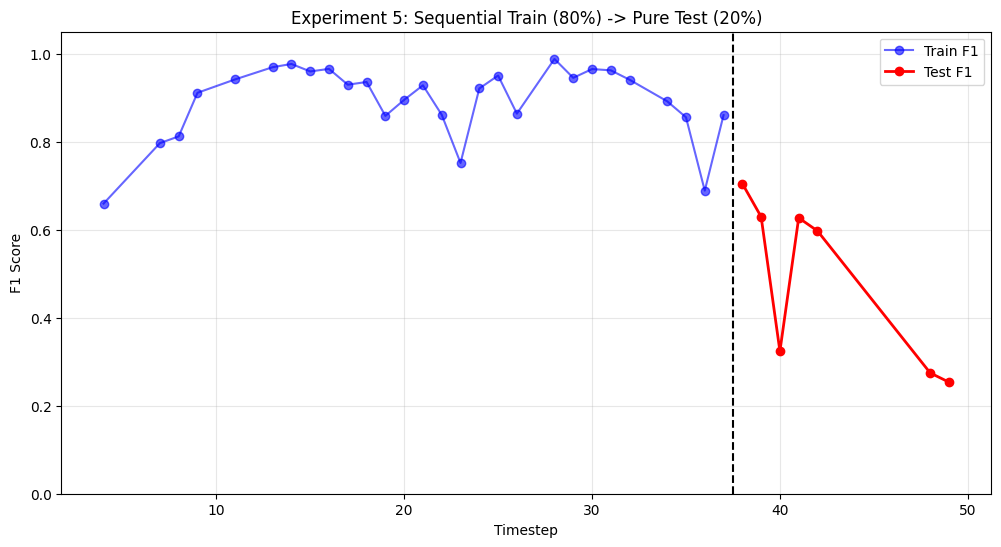


Experiment 5 Test Set Summary:
       accuracy  precision  recall      f1  auc_roc
count    7.0000     7.0000  7.0000  7.0000   7.0000
mean     0.8979     0.5246  0.5239  0.4872   0.8575
std      0.0443     0.1434  0.2500  0.1940   0.0675
min      0.8035     0.2375  0.1607  0.2535   0.7450
25%      0.8967     0.5006  0.3517  0.2992   0.8280
50%      0.9114     0.5630  0.6360  0.5972   0.8479
75%      0.9192     0.5904  0.7009  0.6282   0.9078
max      0.9383     0.6897  0.7654  0.7048   0.9381


In [31]:
# Experiment 5 Implementation

# 1. Define Split
num_valid = len(valid_timesteps)
split_idx = int(num_valid * 0.8)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Total Valid Timesteps: {num_valid}")
print(f"Training Steps ({len(train_timesteps)}): {train_timesteps}")
print(f"Testing Steps ({len(test_timesteps)}): {test_timesteps}")

# 2. Initialize New Model
model_exp5 = GCNFraudDetector(in_features=x.shape[1]).to(device)
optimizer_exp5 = torch.optim.Adam(model_exp5.parameters(), lr=0.01)

results_exp5 = []

print("\nStarting Experiment 5...")
print(f"{'Timestep':<10} {'Phase':<10} {'Accuracy':<12} {'Precision':<12} {'F1':<10} {'Recall':<10} {'Illicit Count'}")
print("-" * 80)

# 3. Train Phase Loop
for t in train_timesteps:
    # Create mask
    current_mask = ((time_steps == t) & (y > 0))
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    # Train
    class_weights = compute_class_weights(y[current_mask], device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    model_exp5.train()
    for epoch in range(NUM_EPOCHS):
        optimizer_exp5.zero_grad()
        out = model_exp5(x, edge_index)
        loss = criterion(out[current_mask], y[current_mask])
        loss.backward()
        optimizer_exp5.step()
        
    # Optional: Evaluate on train set to track progress (using same eval function)
    metrics = evaluate(model_exp5, x, edge_index, current_mask, y)
    metrics['timestep'] = t
    metrics['phase'] = 'Train'
    results_exp5.append(metrics)
    print(f"{t:<10} {'TRAIN':<10} {metrics['accuracy']:.4f}       {metrics['precision']:.4f}       {metrics['f1']:.4f}     {metrics['recall']:.4f}     {n_illicit}")

print("-" * 80)
print("Switching to PURE TEST Phase (Weights Frozen)...")
print("-" * 80)

# 4. Test Phase Loop
for t in test_timesteps:
    # Create mask
    current_mask = ((time_steps == t) & (y > 0))
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    
    # Evaluate ONLY (No training)
    metrics = evaluate(model_exp5, x, edge_index, current_mask, y)
    metrics['timestep'] = t
    metrics['phase'] = 'Test'
    results_exp5.append(metrics)
    print(f"{t:<10} {'TEST':<10} {metrics['accuracy']:.4f}       {metrics['precision']:.4f}       {metrics['f1']:.4f}     {metrics['recall']:.4f}     {n_illicit}")

# Visualization
res5_df = pd.DataFrame(results_exp5)
train_df = res5_df[res5_df['phase'] == 'Train']
test_df = res5_df[res5_df['phase'] == 'Test']

plt.figure(figsize=(12, 6))
plt.plot(train_df['timestep'], train_df['f1'], marker='o', label='Train F1', color='blue', alpha=0.6)
plt.plot(test_df['timestep'], test_df['f1'], marker='o', label='Test F1', color='red', linewidth=2)

plt.title('Experiment 5: Sequential Train (80%) -> Pure Test (20%)')
plt.xlabel('Timestep')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Mark split point
if len(test_timesteps) > 0:
    plt.axvline(x=test_timesteps[0]-0.5, color='black', linestyle='--', label='Train/Test Split')

plt.show()

print("\nExperiment 5 Test Set Summary:")
print(test_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].describe().round(4))

## Experiment 5: Pooled Test Set Evaluation

The above metrics are **macro-averaged** (mean across timesteps). For fair comparison to baseline models which use **pooled evaluation**, we also compute metrics on the combined test set.

In [35]:
# Experiment 5: Pooled Test Set Evaluation (Micro-averaged)
# Combine all test timesteps into a single mask and evaluate once

print("=" * 80)
print("EXPERIMENT 5: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Create combined test mask for all test timesteps
test_mask_pooled = torch.zeros(len(y), dtype=torch.bool).to(device)
for t in test_timesteps:
    test_mask_pooled |= ((time_steps == t) & (y > 0))

# Count total nodes
n_test_nodes = test_mask_pooled.sum().item()
n_test_illicit = ((y[test_mask_pooled] == 1).sum().item())
n_test_licit = ((y[test_mask_pooled] == 2).sum().item())

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_test_nodes}")
print(f"  Illicit: {n_test_illicit} ({n_test_illicit/n_test_nodes*100:.2f}%)")
print(f"  Licit: {n_test_licit} ({n_test_licit/n_test_nodes*100:.2f}%)")

# Evaluate on pooled test set
pooled_metrics = evaluate(model_exp5, x, edge_index, test_mask_pooled, y)

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics['auc_roc']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {test_df['f1'].mean()*100:.2f}%, Precision: {test_df['precision'].mean()*100:.2f}%, Recall: {test_df['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_test_nodes} nodes):")
print(f"    F1: {pooled_metrics['f1']*100:.2f}%, Precision: {pooled_metrics['precision']*100:.2f}%, Recall: {pooled_metrics['recall']*100:.2f}%")

EXPERIMENT 5: POOLED TEST SET EVALUATION (MICRO-AVERAGED)

Pooled Test Set Composition:
  Timesteps: [38, 39, 40, 41, 42, 48, 49]
  Total nodes: 7383
  Illicit: 751 (10.17%)
  Licit: 6632 (89.83%)

POOLED TEST SET METRICS (for comparison to baseline models)
Accuracy:  89.61%
Precision: 49.12%
Recall:    59.39%
F1 Score:  53.77%
AUC-ROC:   0.8585

Comparison:
  Macro-averaged (mean of 7 timesteps):
    F1: 48.72%, Precision: 52.46%, Recall: 52.39%
  Micro-averaged (pooled 7383 nodes):
    F1: 53.77%, Precision: 49.12%, Recall: 59.39%


# Experiment 6: True Sequential Learning (Reduced Epochs)

## Motivation
Experiments 4 and 5 used **50 epochs per timestep**, which causes:
1. **Catastrophic forgetting**: Each timestep overwrites knowledge from previous timesteps
2. **Not truly sequential**: The model becomes 35 independent models, not a continually learning system

## Approach
We test different epoch counts (1, 3, 5, 10) to find the optimal balance between:
- **Adaptation**: Learning from the new timestep
- **Retention**: Maintaining knowledge from previous timesteps

This experiment uses the same 80/20 train/test split as Experiment 5.

In [36]:
# Experiment 6: Compare different epoch counts
import copy

def run_experiment_6(epochs_per_timestep, exp_name):
    """
    Run sequential training with specified number of epochs per timestep
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT 6.{exp_name}: {epochs_per_timestep} epochs per timestep")
    print(f"{'='*80}\n")
    
    # Initialize new model
    model_exp6 = GCNFraudDetector(in_features=x.shape[1]).to(device)
    optimizer_exp6 = torch.optim.Adam(model_exp6.parameters(), lr=0.01)
    
    print(f"{'Timestep':<10} {'Phase':<10}")
    print("-" * 25)
    
    # Train Phase Loop
    for t in train_timesteps:
        current_mask = ((time_steps == t) & (y > 0))
        
        # Train with reduced epochs
        class_weights = compute_class_weights(y[current_mask], device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        model_exp6.train()
        for epoch in range(epochs_per_timestep):
            optimizer_exp6.zero_grad()
            out = model_exp6(x, edge_index)
            loss = criterion(out[current_mask], y[current_mask])
            loss.backward()
            optimizer_exp6.step()
        
        print(f"{t:<10} {'TRAIN':<10}")
    
    print("-" * 25)
    print("PURE TEST Phase (Weights Frozen)...")
    print("-" * 25)
    
    # Test Phase Loop - no per-timestep evaluation
    for t in test_timesteps:
        print(f"{t:<10} {'TEST':<10}")
    
    # Compute pooled test metrics ONLY
    test_mask_pooled_exp6 = torch.zeros(len(y), dtype=torch.bool).to(device)
    for t in test_timesteps:
        test_mask_pooled_exp6 |= ((time_steps == t) & (y > 0))
    
    pooled_metrics_exp6 = evaluate(model_exp6, x, edge_index, test_mask_pooled_exp6, y)
    
    print(f"\n{'='*80}")
    print(f"POOLED TEST METRICS (Exp 6.{exp_name})")
    print(f"{'='*80}")
    print(f"Accuracy:  {pooled_metrics_exp6['accuracy']*100:.2f}%")
    print(f"Precision: {pooled_metrics_exp6['precision']*100:.2f}%")
    print(f"Recall:    {pooled_metrics_exp6['recall']*100:.2f}%")
    print(f"F1 Score:  {pooled_metrics_exp6['f1']*100:.2f}%")
    print(f"AUC-ROC:   {pooled_metrics_exp6['auc_roc']:.4f}")
    print(f"{'='*80}\n")
    
    return pooled_metrics_exp6

# Run experiments with different epoch counts
all_pooled = {}

for epochs, exp_id in [(1, 'A'), (3, 'B'), (5, 'C'), (10, 'D')]:
    pooled = run_experiment_6(epochs, exp_id)
    all_pooled[epochs] = pooled


EXPERIMENT 6.A: 1 epochs per timestep

Timestep   Phase     
-------------------------
4          TRAIN     
7          TRAIN     
8          TRAIN     
9          TRAIN     
11         TRAIN     
13         TRAIN     
14         TRAIN     
15         TRAIN     
16         TRAIN     
17         TRAIN     
18         TRAIN     
19         TRAIN     
20         TRAIN     
21         TRAIN     
22         TRAIN     
23         TRAIN     
24         TRAIN     
25         TRAIN     
26         TRAIN     
28         TRAIN     
29         TRAIN     
30         TRAIN     
31         TRAIN     
32         TRAIN     
34         TRAIN     
35         TRAIN     
36         TRAIN     
37         TRAIN     
-------------------------
PURE TEST Phase (Weights Frozen)...
-------------------------
38         TEST      
39         TEST      
40         TEST      
41         TEST      
42         TEST      
48         TEST      
49         TEST      

POOLED TEST METRICS (Exp 6.A)
Accuracy:  80.28%
Preci


EXPERIMENT 6: POOLED TEST METRICS COMPARISON
 Epochs/Step  Pooled F1  Pooled Precision  Pooled Recall  Pooled Accuracy  Pooled AUC
           1   0.418066          0.298686       0.696405         0.802790    0.839257
           3   0.302485          0.180240       0.940080         0.558987    0.851189
           5   0.360638          0.227225       0.873502         0.684952    0.873824
          10   0.356754          0.221507       0.916112         0.663958    0.887972
          50   0.537673          0.491189       0.593875         0.896113    0.858528


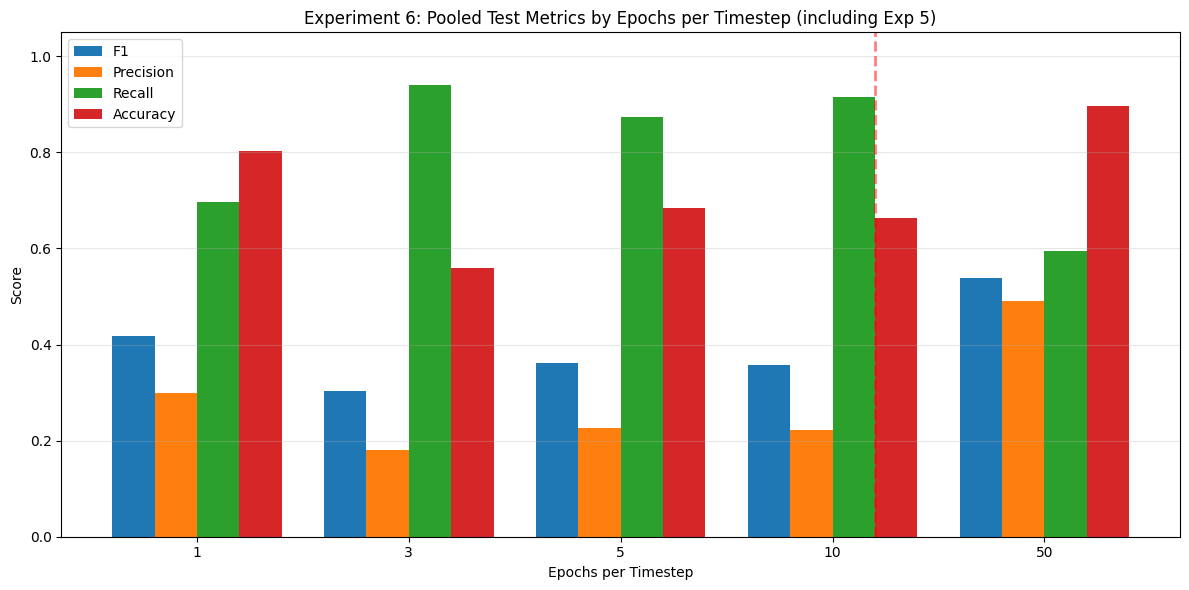


KEY INSIGHTS
Best Pooled F1: 50 epochs/step (F1=53.77%)
Best Pooled AUC: 10 epochs/step (AUC=0.8880)

Trend Analysis:
  Epochs/Step:  [ 1  3  5 10 50]
  F1 scores:    ['0.4181', '0.3025', '0.3606', '0.3568', '0.5377']
  AUC scores:   ['0.8393', '0.8512', '0.8738', '0.8880', '0.8585']

  Comparison to Baseline (Exp 5 - 50 epochs):
    Best F1 improvement:  +0.00 percentage points
    Best AUC improvement: +2.9444 points


In [39]:
# Experiment 6: Comparative Visualization and Analysis

# Create comparison table - POOLED METRICS ONLY
comparison_data = []

# Add Experiment 6 results (1, 3, 5, 10 epochs)
for epochs in [1, 3, 5, 10]:
    pooled = all_pooled[epochs]
    
    comparison_data.append({
        'Epochs/Step': epochs,
        'Pooled F1': pooled['f1'],
        'Pooled Precision': pooled['precision'],
        'Pooled Recall': pooled['recall'],
        'Pooled Accuracy': pooled['accuracy'],
        'Pooled AUC': pooled['auc_roc']
    })

# Add Experiment 5 (50 epochs) for comparison
comparison_data.append({
    'Epochs/Step': 50,
    'Pooled F1': pooled_metrics['f1'],
    'Pooled Precision': pooled_metrics['precision'],
    'Pooled Recall': pooled_metrics['recall'],
    'Pooled Accuracy': pooled_metrics['accuracy'],
    'Pooled AUC': pooled_metrics['auc_roc']
})

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("EXPERIMENT 6: POOLED TEST METRICS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Visualization: Pooled metrics comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metrics_to_plot = ['Pooled F1', 'Pooled Precision', 'Pooled Recall', 'Pooled Accuracy']
x_pos = np.arange(len([1, 3, 5, 10, 50]))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    ax.bar(x_pos + i*width, values, width, label=metric.replace('Pooled ', ''))

ax.set_title('Experiment 6: Pooled Test Metrics by Epochs per Timestep (including Exp 5)')
ax.set_xlabel('Epochs per Timestep')
ax.set_ylabel('Score')
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels([1, 3, 5, 10, 50])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.05)

# Add vertical line to separate Exp 6 from Exp 5
ax.axvline(x=3.5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Exp 5 (50 epochs)')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_f1_idx = comparison_df['Pooled F1'].idxmax()
best_auc_idx = comparison_df['Pooled AUC'].idxmax()

print(f"Best Pooled F1: {comparison_df.loc[best_f1_idx, 'Epochs/Step']} epochs/step "
      f"(F1={comparison_df.loc[best_f1_idx, 'Pooled F1']*100:.2f}%)")
print(f"Best Pooled AUC: {comparison_df.loc[best_auc_idx, 'Epochs/Step']} epochs/step "
      f"(AUC={comparison_df.loc[best_auc_idx, 'Pooled AUC']:.4f})")

print(f"\nTrend Analysis:")
print(f"  Epochs/Step:  {comparison_df['Epochs/Step'].values}")
print(f"  F1 scores:    {[f'{v:.4f}' for v in comparison_df['Pooled F1'].values]}")
print(f"  AUC scores:   {[f'{v:.4f}' for v in comparison_df['Pooled AUC'].values]}")

# Calculate improvement
f1_improvement = (comparison_df.loc[best_f1_idx, 'Pooled F1'] - pooled_metrics['f1']) * 100
auc_improvement = (comparison_df.loc[best_auc_idx, 'Pooled AUC'] - pooled_metrics['auc_roc']) * 100

print(f"\n  Comparison to Baseline (Exp 5 - 50 epochs):")
print(f"    Best F1 improvement:  {f1_improvement:+.2f} percentage points")
print(f"    Best AUC improvement: {auc_improvement:+.4f} points")
print("="*80)